In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance

from model import Model

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 20)
pd.set_option('precision', 2)

e:\python\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
e:\python\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
e:\python\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
e:\python\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

In [2]:
columns = [f'HE{i:02d}' for i in range(1, 25)]


def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear

    X = df[['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year', 'day_of_month', 'week_of_year']]
    if label:
        y = df[label]
        return X, y
    return X

In [3]:
def read_data(data_file, sheet_names) -> pd.DataFrame:
    def get_data_per_sheet(sheet_name):
        df = pd.read_excel(data_file, parse_dates=['DATE'], index_col=[0], usecols=['DATE', *columns],
                           sheet_name=sheet_name)

        data = pd.DataFrame()
        for index, row in df.iterrows():
            d = [getattr(row, c) for c in columns]
            t = [pd.to_datetime(index.strftime('%Y-%m-%d') + f' {i - 1:02d}:00:00') for i in range(1, 25)]
            dd = pd.DataFrame(index=[index]).from_dict({'value': d, 'DATE': t})
            dd.set_index('DATE', inplace=True)
            if len(data):
                data = pd.concat([data, dd])
            else:
                data = dd

        return data

    data = get_data_per_sheet(sheet_names[0])
    for sheet_name in sheet_names[1:]:
        data = pd.concat([data, get_data_per_sheet(sheet_name)])

    return data

In [4]:
def get_data(data_path) -> pd.DataFrame:
    if not os.path.exists(data_path):
        sheet_names = list(map(int, data_path[:-5].split('_')[1:]))
        data_name = data_path.split('_')[0]

        if data_name == 'data':

            data2014 = read_data('2014PJM数据.xls', sheet_names)
            data2015 = read_data('2015PJM数据.xls', sheet_names)
            data2016 = read_data('2016PJM数据.xls', sheet_names)

            data = pd.concat([data2014, data2015, data2016])
        else:
            data = read_data(f'{data_name}PJM数据.xls', sheet_names)

        data.to_excel(data_path)

    else:
        data = pd.read_excel(data_path, index_col=[0], parse_dates=['DATE'])

    return data

In [5]:
data_path = 'data_0.xlsx'
data = get_data(data_path)

In [6]:
sorted(set(data.index.to_list()))

[Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-01-01 01:00:00'),
 Timestamp('2014-01-01 02:00:00'),
 Timestamp('2014-01-01 03:00:00'),
 Timestamp('2014-01-01 04:00:00'),
 Timestamp('2014-01-01 05:00:00'),
 Timestamp('2014-01-01 06:00:00'),
 Timestamp('2014-01-01 07:00:00'),
 Timestamp('2014-01-01 08:00:00'),
 Timestamp('2014-01-01 09:00:00'),
 Timestamp('2014-01-01 10:00:00'),
 Timestamp('2014-01-01 11:00:00'),
 Timestamp('2014-01-01 12:00:00'),
 Timestamp('2014-01-01 13:00:00'),
 Timestamp('2014-01-01 14:00:00'),
 Timestamp('2014-01-01 15:00:00'),
 Timestamp('2014-01-01 16:00:00'),
 Timestamp('2014-01-01 17:00:00'),
 Timestamp('2014-01-01 18:00:00'),
 Timestamp('2014-01-01 19:00:00'),
 Timestamp('2014-01-01 20:00:00'),
 Timestamp('2014-01-01 21:00:00'),
 Timestamp('2014-01-01 22:00:00'),
 Timestamp('2014-01-01 23:00:00'),
 Timestamp('2014-01-02 00:00:00'),
 Timestamp('2014-01-02 01:00:00'),
 Timestamp('2014-01-02 02:00:00'),
 Timestamp('2014-01-02 03:00:00'),
 Timestamp('2014-01-

In [7]:
split_ratio = 0.95
split_index = int(len(data) * split_ratio)
split_date = data.iloc[split_index].name
train_data = data.iloc[:split_index].copy()
test_data = data.iloc[split_index:].copy()
print(f'split_date={split_date}, len(train_data)={len(train_data)},len(test_data)={len(test_data)}')

split_date=2016-11-07 04:00:00, len(train_data)=24988,len(test_data)=1316


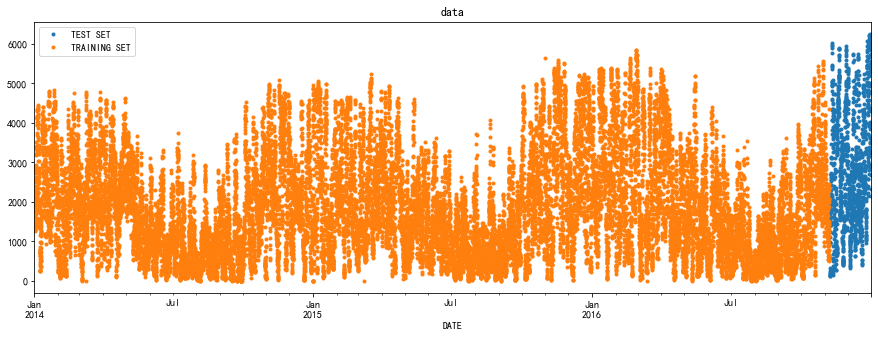

In [8]:
_ = test_data \
    .rename(columns={'value': 'TEST SET'}) \
    .join(train_data.rename(columns={'value': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15, 5), title='data', style='.')
plt.show()

In [9]:
# 训练集
X_train, y_train = create_features(train_data, label='value')
# 测试集
X_test, y_test = create_features(test_data, label='value')
# 模型

In [10]:
# 模型
reg =Model(n_estimators=10000,args=None)
# 训练
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=100, verbose=True)

[0]	validation_0-rmse:1710.03223	validation_1-rmse:2550.27930
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:1375.94263	validation_1-rmse:2097.46973
[2]	validation_0-rmse:1171.56885	validation_1-rmse:1855.87219
[3]	validation_0-rmse:1047.56323	validation_1-rmse:1739.01025
[4]	validation_0-rmse:977.04962	validation_1-rmse:1669.20825
[5]	validation_0-rmse:929.42566	validation_1-rmse:1644.43188
[6]	validation_0-rmse:905.42364	validation_1-rmse:1627.10327
[7]	validation_0-rmse:885.96619	validation_1-rmse:1621.08630
[8]	validation_0-rmse:877.03156	validation_1-rmse:1616.15930
[9]	validation_0-rmse:868.86877	validation_1-rmse:1616.94177
[10]	validation_0-rmse:851.75494	validation_1-rmse:1604.67041
[11]	validation_0-rmse:848.15961	validation_1-rmse:1604.69019
[12]	validation_0-rmse:830.34106	validation_1-rmse:1605.37109
[13]	validation_0-rmse:824.74762	validat

Model(args=None, base_score=0.5, booster=None, colsample_bylevel=1,
      colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
      importance_type='gain', interaction_constraints=None,
      learning_rate=0.300000012, max_delta_step=0, max_depth=6,
      min_child_weight=1, missing=nan, monotone_constraints=None,
      n_estimators=10000, n_jobs=0, num_parallel_tree=1,
      objective='reg:squarederror', random_state=0, reg_alpha=0, reg_lambda=1,
      scale_pos_weight=1, subsample=1, training=None, tree_method=None,
      validate_parameters=False, verbosity=None)

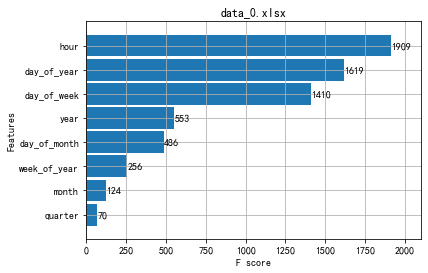

In [11]:
# 分析重要程度
_ = plot_importance(reg, height=0.9, title=data_path)
plt.show()

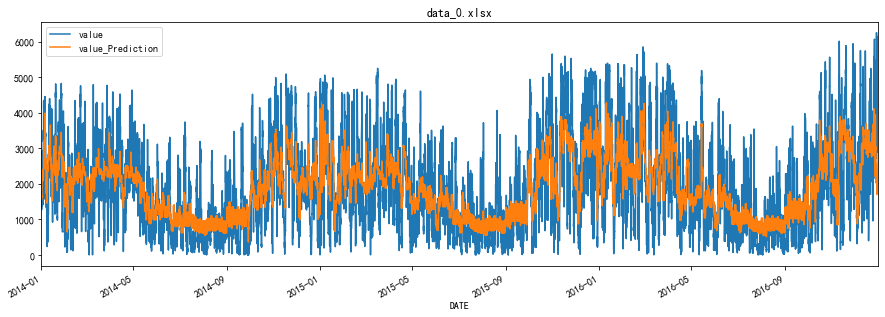

In [12]:
# 预测结果
test_data['value_Prediction'] = reg.predict(X_test)
train_data['value_Prediction'] = reg.predict(X_train)
pjme_all = pd.concat([test_data, train_data], sort=False)
_ = pjme_all[['value', 'value_Prediction']].plot(figsize=(15, 5))
plt.title(data_path)
plt.show()

In [13]:
# 指定日期范围内画出预测结果与真实结果作对比
def plot_predict_days(lower, upper):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    _ = pjme_all[['value_Prediction', 'value']].plot(ax=ax,
                                                     style=['-', '.'])
    ax.set_xbound(lower=lower, upper=upper)
    # ax.set_ylim(0, 60000)
    plot = plt.suptitle('Forecast vs Actuals')
    plt.show()

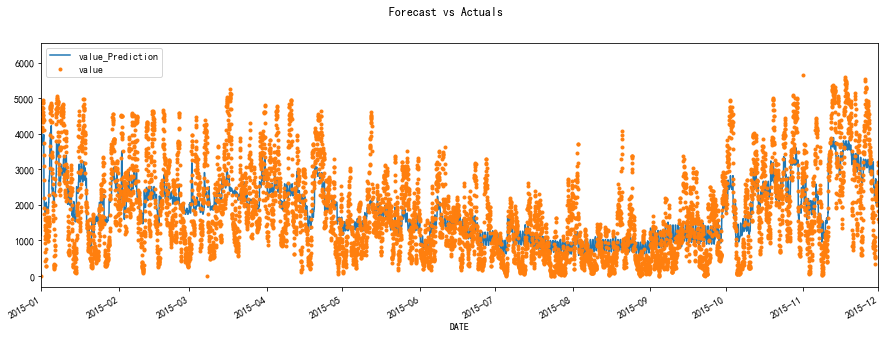

In [14]:
plot_predict_days(lower='01-01-2015', upper='12-01-2015')

In [15]:
# 评估MSE
print(mean_squared_error(y_true=test_data['value'],
                         y_pred=test_data['value_Prediction']))

2574967.4378524246


In [16]:
# 评估MAE
print(mean_absolute_error(y_true=test_data['value'],
                          y_pred=test_data['value_Prediction']))

1316.4848984293371


In [17]:
# 评估MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


print(mean_absolute_percentage_error(y_true=test_data['value'],
                                     y_pred=test_data['value_Prediction']))

87.06015561608218


In [18]:
# 最好的和最坏的结果
test_data['error'] = test_data['value'] - test_data['value_Prediction']
test_data['abs_error'] = test_data['error'].apply(np.abs)
error_by_day = test_data.groupby(['year', 'month', 'day_of_month']) \
    .mean()[['value', 'value_Prediction', 'error', 'abs_error']]

In [19]:
# 最坏的前十天
print(error_by_day.sort_values('abs_error', ascending=False).head(10))

                           value  value_Prediction    error  abs_error
year month day_of_month                                               
2016 12    29            5762.10           2386.53  3375.57    3375.57
     11    12             824.43           3690.00 -2865.57    2865.57
     12    30            4860.99           2187.71  2673.28    2673.28
           31            4778.26           2251.74  2526.52    2554.27
           8             4597.47           2183.16  2414.31    2414.31
     11    15            1077.77           3485.78 -2408.01    2408.01
     12    19            1149.55           3368.84 -2219.29    2219.29
     11    16            1451.43           3648.70 -2197.27    2197.27
     12    1             4371.41           2234.03  2137.38    2137.38
     11    25             926.85           3044.92 -2118.07    2118.07


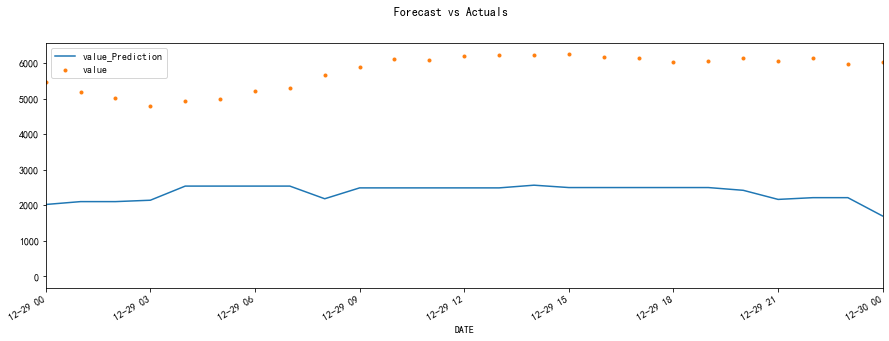

In [20]:
plot_predict_days(lower='12-29-2016', upper='12-30-2016')

In [21]:
# 最好的前十天
print(error_by_day.sort_values('abs_error', ascending=True).head(10))

                           value  value_Prediction   error  abs_error
year month day_of_month                                              
2016 12    2             2305.81           1997.12  308.69     333.28
     11    22            3067.71           3396.15 -328.44     419.88
     12    3             1379.86           1714.30 -334.44     427.62
     11    17            3831.52           3648.70  182.82     440.27
     12    11            3145.44           2786.74  358.70     464.54
           23            2822.70           2892.10  -69.40     473.55
           7             2492.09           2238.75  253.34     536.95
           5             1875.12           1355.93  519.18     595.45
     11    27            3097.53           2913.38  184.15     607.24
     12    6             2170.84           1602.48  568.36     620.49


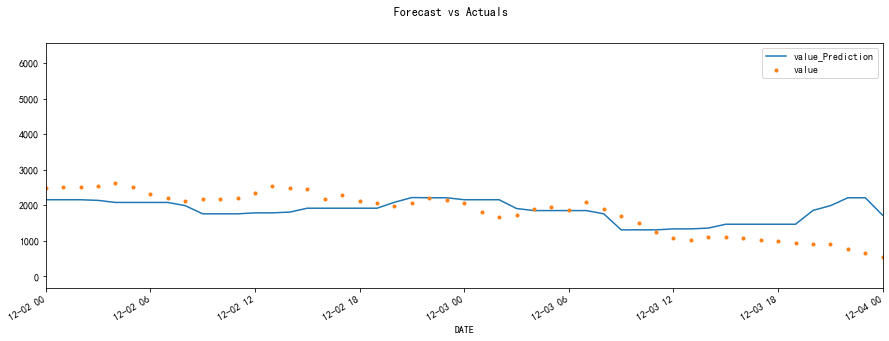

In [22]:
plot_predict_days(lower='12-2-2016', upper='12-4-2016')